# An Implementation of the QAOA

In this tutorial, we'll use the quantum approximate optimization algorithm (QAOA) to find an approximate solution to the minimum vertex cover problem. We'll use Covalent to dispatch, organize, and track our computations every step of the way -- culminating in two workflows, each demonstrating a different way of using Covalent for easy experimentation.


**QAOA** is an algoithm that can provide approximate solutions to combinatorial optimization problems -- problems aimed at optimmizing some cost function containing a finite set of nodes. Many combinatorial optimization problems are NP-hard, making it computationally expensive to find an exact solution. Methods like QAOA get around that by instead finding approximate solutions. QAOA is a very simple algorithm that can function with little error correction and shallow circuit depths, so it is particularly well-suited to be run on NISQ (noisy intermediate-scale quantum) devices.

QAOA problems consist of some bit string *z* and a clause *C*. Each item in the bit string is binary-valued, i.e. $z \in {0,1}^n$, where *n* is the total number of bits. The clause $C(z)$ can be represented,
 
$$ C_\alpha= 
\begin{array}{ll}
    1, & \textrm{ if z satisfies clause } C_\alpha \\
    0, & \textrm{ otherwise.} \\
\end{array} $$

The full clause satisfaction problem is treated as the summation over all clauses, $C(z) = \sum_{\alpha = 1}^{m} C_\alpha (z)$, where *m* is the total number of clauses.

## The Minimum Vertex Cover Problem

The goal of the vertex cover problem is to find the *minimum* number of vertices needed in order to "cover" all edges in a graph. That is, we want to choose the fewest number of vertices such that every edge in the graph touches at least one chosen vertex. Determining the minimum vertex cover is an NP-complete problem, meaning that there is no known exact solution that can be found in polynomial time.

In this problem, the bit string *z* consists of all vertices in the graph. A vertex is assigned a value of 1 if it is selected, and a value of 0 if it is not. 

<figure>
  <img src="min_vertex.png" alt="min_vertex" style="width:50%">
  <figcaption>Figure 1: A minimum vertex cover example, where chosen vertices and their associated edges are shown in blue. <i>(a)</i> No vertices are chosen, so no edge is covered. <i>(b)</i> Two vertices are chosen, but not all edges in the graph are covered. <i>(c)</i> Four vertices are chosen and all edges are covered, but this is not the minimum number of vertices to cover all edges. <i>(d)</i> Two vertices are chosen and all edges are covered.</figcaption>
</figure>

In our experiment below, we will use the Python *networkx* package to generate graphs, and minimize the number of chosen vertices.

We begin by importing all necessary packages.

In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

# Covalent
import covalent as ct

[Internal] This step is there for now because of the Dask optimization issue; the environment I am using to execute this script has Covalent Version 0.33.0

In [2]:
from dask.distributed import LocalCluster
cluster=LocalCluster()
dask=ct.executor.DaskExecutor(scheduler_address=cluster.scheduler_address)

# Setting up Slurm Executor (Internal)

Install using `pip install covalent-slurm-plugin`

You'll need to make edits to the username, keyfile, remote_work, and options. You'll also need to set up an ssh key that isn't password protected. Also make sure you have covalent and the latest pennylane installed on beehive.

In [3]:
from covalent.executor import SlurmExecutor

username="anna"
address="beehive.agnostiq.ai"
keyfile="/Users/annahughes/.ssh/beehive_key"
remote_workdir="/federation/anna/covalent_workdir"
poll_freq=60
options={"partition": "debug", "cpus-per-task": 2, "ntasks": 1, "nodelist": "beehive-debug-st-t2medium-1",
         "chdir": "/federation/anna/covalent_workdir"}

In [4]:
slurm_exec = SlurmExecutor(username=username,address=address,ssh_key_file=keyfile,remote_workdir=remote_workdir,poll_freq=poll_freq,options=options)

We include the following functions:

`make_graph`: Generates our graphs for a given number of nodes *n* (determined by the number of qubits) and probability *p* for edge creation at each node. Pennylane returns the QAOA cost and mixer Hamiltonians for the generated graph.

`get_circuit`: This electron includes two functions. `qaoa_layer` generates the cost and mixer layers given the Hamiltonians computed in the previous step and variational parameters *alpha* and *gamma*. `circuit` creates a quantum circuit from a Hadamard gate and the cost and mixer layers.

`make_cost_function`: Defines the simulator *dev* and computes the expectation value of the input circuit for a given cost Hamiltonian.

`get_random_initialization`: Generates two random seed values between 0 and $2\pi$ from a uniform distribution.

`initialize_parameters`: Calls all previous functions to create initial values for the cost and mixer Hamiltonians, the resulting circuit, the cost function, the initial angles. Only the cost function and initial angles are returned.

`calculate_cost`: For an input optimizer, this function computes and returns the value of the cost function and progresses the optimizer by one step, updating the trainable parameters.

  (-0.25) [Z1]
+ (0.5) [Z0]
+ (0.5) [Z3]
+ (1.25) [Z2]
+ (0.75) [Z0 Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


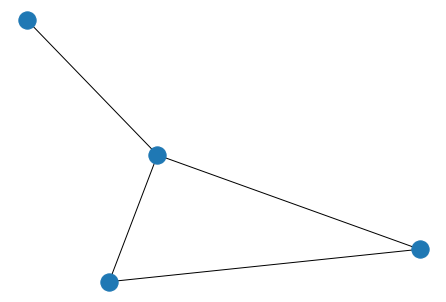

In [30]:
graph = nx.generators.random_graphs.gnp_random_graph(n=4,p=0.5)
nx.draw(graph)
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
print(cost_h, mixer_h)

In [17]:
@ct.electron
def make_graph(qubits,prob):
    graph = nx.generators.random_graphs.gnp_random_graph(n=qubits,p=prob)
    cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
    return cost_h,mixer_h


@ct.electron
def get_circuit(cost_h,mixer_h):
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
        
        
    def circuit(params,wires, **kwargs):
        depth=params.shape[1]
        for w in range(wires):
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, params[0], params[1])
    return circuit

@ct.electron
def make_cost_function(circuit,cost_h,qubits):
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params,wires=qubits)
        return qml.expval(cost_h)

    return cost_function


@ct.electron
def get_random_initialization(p=1,seed=0):
    np.random.seed(seed)
    return np.random.uniform(0,2*np.pi,(2,p),requires_grad=True)

@ct.electron
def initialize_parameters(p=1,qubits=2,prob=0.3,seed=1):
    cost_h,mixer_h=make_graph(qubits=qubits,prob=prob)
    circuit=get_circuit(cost_h,mixer_h)
    cost_function=make_cost_function(circuit,cost_h,qubits)
    initial_angles=get_random_initialization(p=p,seed=seed)
    return cost_function,initial_angles

@ct.electron
def calculate_cost(cost_function,params,optimizer):
    params,loss=optimizer.step_and_cost(cost_function, params)
    return optimizer,params,loss



For simulations, where full optimization is costly but individual steps are not costly. We make the workflow to include multiple such optimization steps by making the entire optimization an electron

In [6]:
@ct.electron(executor=dask)
#@ct.electron(executor=slurm_exec)
def optimize_electron(cost_function,init_angles, optimizer=qml.GradientDescentOptimizer(),iterations=10):
    loss_history=[]
    params = init_angles
    for _ in range(iterations):
        optimizer,params,loss=calculate_cost(cost_function=cost_function,params=params,optimizer=optimizer)
        loss_history.append(loss)
    return loss_history


@ct.electron
def collect_and_mean(array):
    return np.mean(array,axis=0)

# run_exp Workflow

Running this lattice makes the most sense if you're uninterested in saving your intermediate optimization steps, as opposed to the `optimize` lattice. This is ideal for running simulations.
When you start increasing the number of iterations, the runtime will get long, so we should ship the `optimize_electron` step to slurm.
It's in the `optimize_electron` function that you can play around with the initial angles, and specify the optimizer you want to use. Compare_optimizers exists in order to compare the results from using different the PennyLane optimizers, i.e. GradientDescentOptimizer, AdagradOptimizer, MomentumOptimizer.

In [7]:
@ct.electron
def make_graph(qubits,prob):
    graph = nx.generators.random_graphs.gnp_random_graph(n=qubits,p=prob)
    cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
    return cost_h,mixer_h


@ct.electron
def get_circuit(cost_h,mixer_h):
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
        
        
    def circuit(params,wires, **kwargs):
        depth=params.shape[1]
        for w in range(wires):
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, params[0], params[1])
    return circuit

@ct.electron
def make_cost_function(circuit,cost_h,qubits):
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params,wires=qubits)
        return qml.expval(cost_h)

    return cost_function


@ct.electron
def get_random_initialization(p=1,seed=0):
    np.random.seed(seed)
    return np.random.uniform(0,2*np.pi,(2,p),requires_grad=True)

@ct.electron
def initialize_parameters(p=1,qubits=2,prob=0.3,seed=1):
    cost_h,mixer_h=make_graph(qubits=qubits,prob=prob)
    circuit=get_circuit(cost_h,mixer_h)
    cost_function=make_cost_function(circuit,cost_h,qubits)
    initial_angles=get_random_initialization(p=p,seed=seed)
    return cost_function,initial_angles

@ct.electron
def calculate_cost(cost_function,params,optimizer):
    params,loss=optimizer.step_and_cost(cost_function, params)
    return optimizer,params,loss



In [8]:
@ct.lattice#(executor=dask)
def run_exp(p=1,qubits=2,prob=0.3,seed=[1], optimizers=[qml.GradientDescentOptimizer()],iterations=10):
    compare_optimizers=[]
    for s in seed:
        tmp=[]
        cost_function,init_angles=initialize_parameters(p=p,qubits=qubits,prob=prob,seed=s)
        for optimizer in optimizers:
            loss_history=optimize_electron(cost_function=cost_function,init_angles=init_angles,optimizer=optimizer,iterations=iterations)
            tmp.append(loss_history)
        compare_optimizers.append(tmp)
    return collect_and_mean(compare_optimizers)

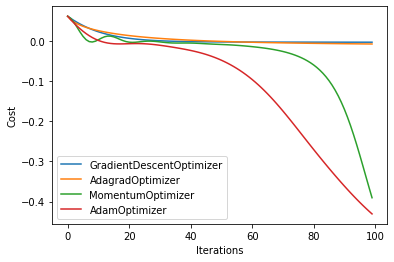

In [9]:
optimizers=[qml.GradientDescentOptimizer(),qml.AdagradOptimizer(),qml.MomentumOptimizer(), qml.AdamOptimizer()]
local_result = run_exp(p=1,qubits=2,prob=1.2,seed=[1], optimizers=optimizers,iterations=100)
simulators = ['GradientDescentOptimizer', 'AdagradOptimizer', 'MomentumOptimizer', 'AdamOptimizer']

for i in range(len(local_result)):
    plt.plot(np.array(local_result[i]).T, label=simulators[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [10]:
#id=ct.dispatch(run_exp)(p=1,qubits=2,prob=0.3,seed=[1], optimizers=[qml.GradientDescentOptimizer()],iterations=100)
id=ct.dispatch(run_exp)(p=1,qubits=2,prob=1.2,seed=[1], optimizers=optimizers,iterations=100)

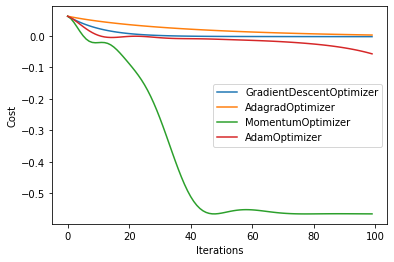

In [11]:
result=ct.get_result(id,wait=True)
result=result.result
simulators = ['GradientDescentOptimizer', 'AdagradOptimizer', 'MomentumOptimizer', 'AdamOptimizer']
for i in range(len(result)):
    plt.plot(np.array(result[i]).T, label=simulators[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

___

In actual QC runs, each step of the optimization is both time and resource costly and hence we would want to monitor not only at the main optimization level, but also at iteration level. The optimization is done within the lattice of this workflow. 
It will take much longer if sent to actual quantum devices due to queues.

From the DAGs you should be able to see how the results are saved as each step.
This is in contrast to the `run_exp` lattice, which is designed for simulation purposes.

In [12]:
@ct.lattice#(executor=dask)
def optimize(p=1,qubits=2,prob=0.3,seed=1, optimizers=[qml.GradientDescentOptimizer()],iterations=10):
    compare_optimizers=[]
    for optimizer in optimizers:
        loss_history=[]
        cost_function,init_angles=initialize_parameters(p=p,qubits=qubits,prob=prob,seed=seed)
        params = init_angles
        for _ in range(iterations):
            optimizer,params,loss=calculate_cost(cost_function=cost_function,params=params,optimizer=optimizer)
            loss_history.append(loss)
        compare_optimizers.append(loss_history)
    return compare_optimizers


In [13]:
iterations=10
seed=1
p=1
qubits=1
prob=0.6
optimizers=[qml.GradientDescentOptimizer(),qml.AdagradOptimizer(),qml.MomentumOptimizer()]
id=ct.dispatch(optimize)(p=p,qubits=qubits,prob=prob,seed=seed,iterations=iterations,optimizers=optimizers)

# Plotting the Comparative Results from Different Simulators

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


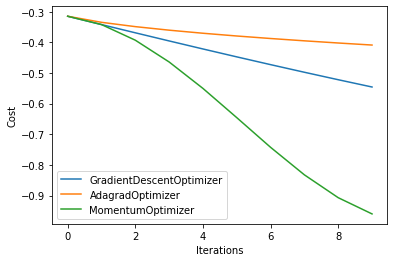

In [14]:
result=ct.get_result(id,wait=True)
result=result.result
for i in range(len(result)):
    plt.plot(np.array(result[i]).T, label=simulators[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Experiments to Run (Internal)

* ### **1. How cost converges with various optimizers**

The infrastructure for this experiment is already built into the code in both the `run_exp` and `optimize` lattices. A sample plot for three optimizers is shown above for the `optimize` workflow.

* ### **2. How the cost function profile looks with various random initial angles**

We can play with a range of angle values input in the `optimize_electron` function in the `run_exp` lattice. By default, the angle values for the `optimize` lattice are set randomly in `initialize_parameters`. We can edit this to iteratively explore a range of angle values.

* ### **3. How the final optimization step/performance looks with respect to the graph params**

In the `make_graph` electron, we can explore how different *prob* values affect the algorithm performance.

* ### **4. Plot the gradient values to reveal barren plateaus**

During the optimization process, if we can get gradient values we can visualize barren plateaus.

* ### **5. Wasserstein Distance**

The Wasserstein distance is a distance metric measuring the difference between two distributions, generally probability distributions.